Importing Libraries

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

loading dataset and splitting into training, testing and validation sets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/data of cats and dogs/CandD'
# Set the train, validation, and test directories
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Verify contents
print("Contents of train_dir:", os.listdir(train_dir))
print("Contents of test_dir:", os.listdir(test_dir))
print("Contents of val_dir:", os.listdir(val_dir))
# Get number of files in each directory
total_train_cats = len(os.listdir(os.path.join(train_dir, 'cats')))
total_train_dogs = len(os.listdir(os.path.join(train_dir, 'dogs')))
total_train = total_train_cats + total_train_dogs

total_val_cats = len(os.listdir(os.path.join(val_dir, 'cats')))
total_val_dogs = len(os.listdir(os.path.join(val_dir, 'dogs')))
total_val = total_val_cats + total_val_dogs

total_test_cats = len(os.listdir(os.path.join(test_dir, 'cats')))
total_test_dogs = len(os.listdir(os.path.join(test_dir, 'dogs')))
total_test = total_test_cats + total_test_dogs

# Using the test set as validation set
total_val = total_test

print(f"Total training images: {total_train} (Cats: {total_train_cats}, Dogs: {total_train_dogs})")
print(f"Total validation images: {total_val} (Cats: {total_test_cats}, Dogs: {total_test_dogs})")
print(f"Total test images: {total_test} (Cats: {total_test_cats}, Dogs: {total_test_dogs})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of train_dir: ['dogs', 'cats']
Contents of test_dir: ['dogs', 'cats']
Contents of val_dir: ['cats', 'dogs']
Total training images: 445 (Cats: 223, Dogs: 222)
Total validation images: 140 (Cats: 70, Dogs: 70)
Total test images: 140 (Cats: 70, Dogs: 70)


In [3]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
directory=train_dir,
batch_size =batch_size,
target_size=(IMG_HEIGHT, IMG_WIDTH),
class_mode='binary')
val_data_gen =  train_image_generator.flow_from_directory(
directory=val_dir,
batch_size =batch_size,
target_size=(IMG_HEIGHT, IMG_WIDTH),
class_mode='binary')
test_data_gen =  train_image_generator.flow_from_directory(
directory=test_dir,
batch_size =batch_size,
target_size=(IMG_HEIGHT, IMG_WIDTH),
shuffle=False,
class_mode='binary')

Found 445 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


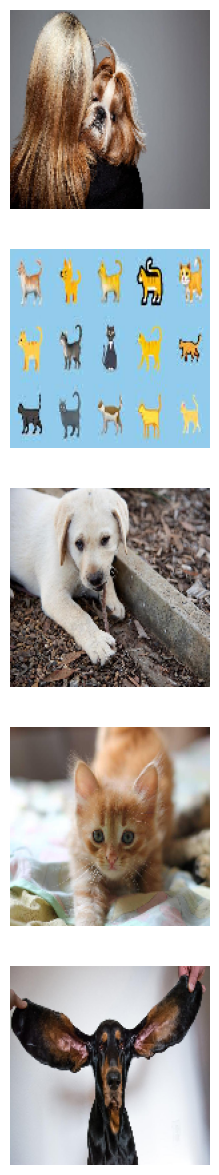

In [6]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [7]:
train_image_generator = ImageDataGenerator(
rescale=1./255,
rotation_range=45,
width_shift_range=.15,
height_shift_range=.15,
horizontal_flip=True,
zoom_range=0.5
)

Found 445 images belonging to 2 classes.


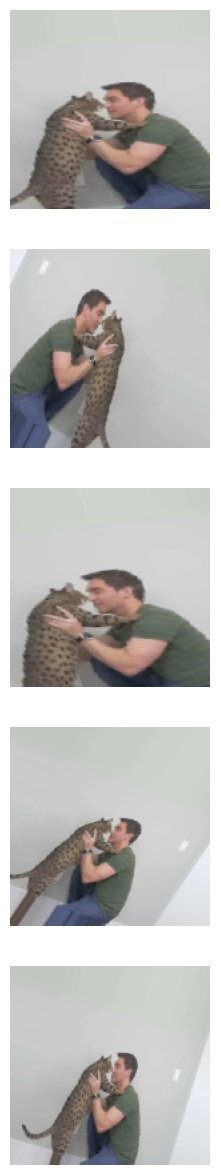

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])





model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [16]:
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=15,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)

Epoch 1/15
3/3 [==============================] - 30s 8s/step - loss: 0.5737 - accuracy: 0.6797 - val_loss: 0.6256 - val_accuracy: 0.6696
Epoch 2/15
3/3 [==============================] - 24s 10s/step - loss: 0.6053 - accuracy: 0.6593 - val_loss: 0.6649 - val_accuracy: 0.6161
Epoch 3/15
3/3 [==============================] - 24s 7s/step - loss: 0.6149 - accuracy: 0.6656 - val_loss: 0.6266 - val_accuracy: 0.6607
Epoch 4/15
3/3 [==============================] - 25s 7s/step - loss: 0.5977 - accuracy: 0.6278 - val_loss: 0.6152 - val_accuracy: 0.6875
Epoch 5/15
3/3 [==============================] - 23s 7s/step - loss: 0.5845 - accuracy: 0.6909 - val_loss: 0.6305 - val_accuracy: 0.6429
Epoch 6/15
3/3 [==============================] - 23s 9s/step - loss: 0.5835 - accuracy: 0.6877 - val_loss: 0.6236 - val_accuracy: 0.6875
Epoch 7/15
3/3 [==============================] - 24s 7s/step - loss: 0.5733 - accuracy: 0.6656 - val_loss: 0.6212 - val_accuracy: 0.6429
Epoch 8/15
3/3 [=================

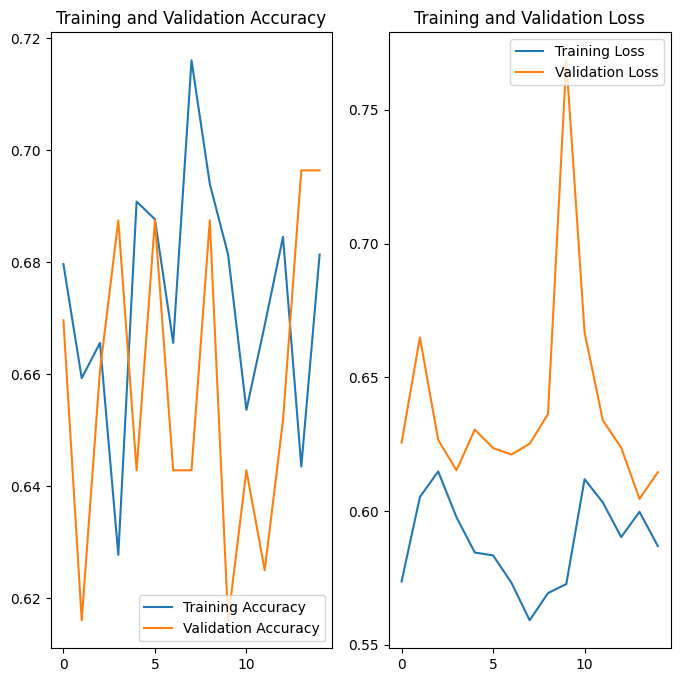

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 [==============================] - 3s 127ms/step


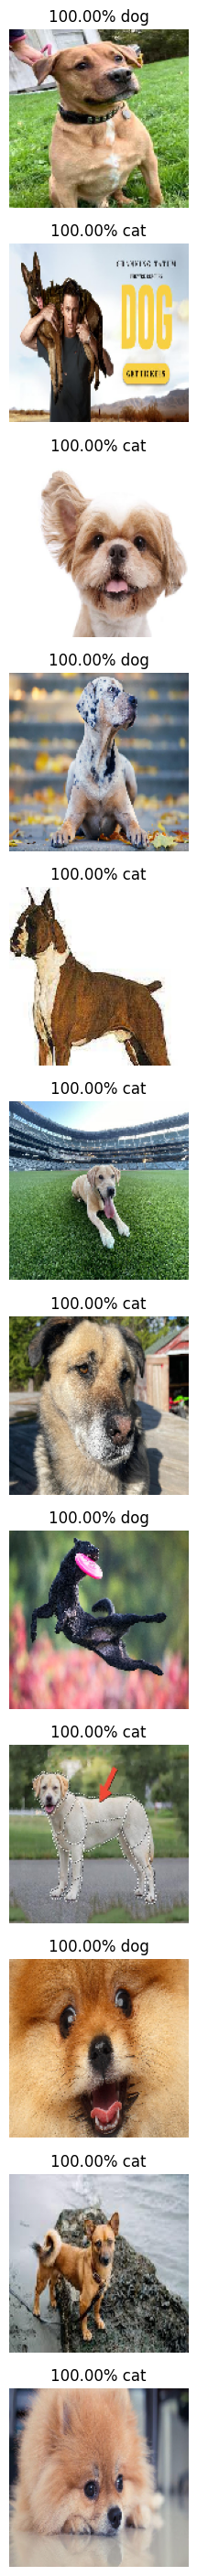

In [18]:
test_images, _ = next(test_data_gen)
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
plotImages(test_images, probabilities=probabilities)

In [13]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified * 100, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 56.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
